<a href="https://colab.research.google.com/github/Gaussiandra/allcups_2020_3/blob/master/solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d96b70cc-90bd-9d90-7583-7f1fb0d71fdf)


In [1]:
!pip install catboost

     |████████████████████████████████| 64.8MB 64kB/s 


In [2]:
!pip install lightfm

     |████████████████████████████████| 307kB 3.4MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=707634 sha256=20fd2a0cf562991e85abfc1691296e9650e31aa1fa338244c326fca21a532fee
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import json
import pickle
import re
import nltk

import lightgbm as lgb
from lightfm import LightFM
from catboost import CatBoostClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm

In [43]:
tqdm.pandas(tqdm)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

global_path = '/content/drive/My Drive/ML/Выявление закономерностей на основе данных МФЦ/'
irkutsk_ds_path = global_path + 'data/dataset_irkutsk/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
categorical_features = [
    #'requester',
    'service',  
    'service_title', 
    'receipt_mfc',
    'internal_status', 
    'external_status',
    'sub_department',  
    'creation_mfc', 
    'order_type', 
    'department_id',
    'deleted', 
    'deleter_fk', 
    'custom_service_id', 
    'service_level',
    'mfc',
    'cpgu_user',
    'text_cluster',
    'emb_item_cluster',

    #'nan_added_col',  
    'previous_service_title',
    'previous_text_cluster',    
    'requester_requester_type', 
    'requester_gender',
    'requester_deleted',
    
    #'cpgu_department_id', 
    'cpgu_department_parent', 
    'cpgu_department_code',
    'cpgu_department_calendar',
    'cpgu_department_department_id',
    'cpgu_department_cluster',

    'cpgu_mfc_id',
    'cpgu_mfc_code', 
    'cpgu_mfc_closed', 
    'cpgu_mfc_branch_id',
    'cpgu_mfc_qms_server_id',
    'cpgu_mfc_deperatment_id', 
    'cpgu_mfc_office_type_id',
    'cpgu_mfc_parent_id', 
    'cpgu_mfc_key_mfc', 
    'cpgu_mfc_calendar',
    'cpgu_mfc_damask_office_id',

    'cpgu_user_auto_ping_queue',

    'cpgu_service_level',
    'cpgu_service_is_not_render',
    'cpgu_service_person',
    'cpgu_service_sole',
    'cpgu_service_legal',

    'custom_service_info_person',
    'custom_service_info_sole',
    'custom_service_info_legal',	
    'custom_service_info_group_title',
    'custom_service_info_department',	
    'custom_service_info_level',	
    'custom_service_info_is_not_render',
    'custom_service_info_deleted',	
    #'custom_service_info_frgu_service_id',

    #'user_to_emb_cluster'
]

# Import data

In [5]:
# Добавить считывание без ошибок и с проставленными типами

csv_tables = {}
for file_name in tqdm(os.listdir(irkutsk_ds_path)[:-6]):
    csv_tables[file_name.replace('.csv', '')] = pd.read_csv(
        irkutsk_ds_path+file_name,
        encoding='cp1251',
        sep=';',
        error_bad_lines=False,
    )

len(csv_tables)

b'Skipping line 5352: expected 5 fields, saw 8\nSkipping line 9698: expected 5 fields, saw 8\nSkipping line 10007: expected 5 fields, saw 8\nSkipping line 10352: expected 5 fields, saw 8\nSkipping line 11724: expected 5 fields, saw 8\nSkipping line 11831: expected 5 fields, saw 8\nSkipping line 27343: expected 5 fields, saw 8\nSkipping line 29624: expected 5 fields, saw 8\n'
b'Skipping line 2128421: expected 5 fields, saw 8\nSkipping line 2128802: expected 5 fields, saw 8\nSkipping line 2130406: expected 5 fields, saw 8\nSkipping line 2131359: expected 5 fields, saw 8\nSkipping line 2132539: expected 5 fields, saw 8\nSkipping line 2143803: expected 5 fields, saw 8\nSkipping line 2153411: expected 5 fields, saw 8\nSkipping line 2159798: expected 5 fields, saw 8\nSkipping line 2175361: expected 5 fields, saw 8\nSkipping line 2175381: expected 5 fields, saw 8\nSkipping line 2180132: expected 5 fields, saw 8\nSkipping line 2181389: expected 5 fields, saw 8\nSkipping line 2187745: expected 

17

In [16]:
train_csv = pd.read_csv(irkutsk_ds_path+'train.csv')

train_csv.columns = train_csv.iloc[-1]
train_csv.drop(2713722, inplace=True)
train_csv.columns.name = None

# Написать в загрузку
train_csv.requester = train_csv.requester.astype(int)
train_csv.service_title = train_csv.service_title.astype(int)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
def handle_type(column):
    try:
        return column.astype(int)
    except:
        try:
            return column.astype(float)
        except:
            print(column.name)
            return column

In [8]:
for name, table in tqdm(csv_tables.items()):
    print('!'+name)
    for col in table.columns:
        table[col] = handle_type(table[col])

!cpgu_department
department_id
code
title
!cpgu_mfc
name
full_name
address
key_mfc
!cpgu_service
description
level
eid
lid
!cpgu_sub_department
title
!cpgu_user
!custom_service_info
title
group_title
level
eid
lid
parent_service_eid
parent_service_lid
!enum_external_order_status
external_order_status
localized_status_name
!enum_order_status
localized_status_name
order_status
!equeue_ticket
id
ticket_number
serving_started
serving_finished
service_name
!equeue_ticket_order_act
equeue_ticket
type
change_timestamp
!MaleFemale
Name
!order_relates
!order_status_history
Last_status_time
!requester
edit_timestamp
!RequesterType
Name
!department
name
!office_type
name



In [4]:
test_ids_txt = open(irkutsk_ds_path+'test_ids.txt', 'r').read().split('\n')
test_ids = pd.Series(test_ids_txt[1:-1], name=test_ids_txt[0], dtype=int)
test_ids

/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:2327: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


0         83029018
1        123998836
2        184301121
3         54344611
4        184299902
           ...    
44439     27213855
44440     64899947
44441     23695212
44442     72707269
44443     38205629
Name: requester, Length: 44444, dtype: int64

In [38]:
service_title_mapping_json = json.load(open(irkutsk_ds_path+'service_title_mapping.json', 'r'))
service_title_mapping_dict = {}

for item in service_title_mapping_json.items():
    service_title_mapping_dict[item[1]] = item[0]

service_title_mapping_dict[0], len(service_title_mapping_dict)

('_Присвоение (аннулирование) адреса объекту адресации', 1310)

In [39]:
id_to_desc = pd.DataFrame.from_records(list(service_title_mapping_dict.items())).drop(0, axis=1)
id_to_desc

,1
0,_Присвоение (аннулирование) адреса объекту адр...
1,Принятие документов для принятия решения о под...
2,_Выдача разрешений на ввод объекта в эксплуата...
3,"Выдача справок о том, является или не является..."
4,"_Предоставление сведений, содержащихся в Едино..."
...,...
1305,Прием расчета по начисленным и уплаченным стра...
1306,Услуга по предоставлению по заданным параметра...
1307,_Принятие решения о предоставлении ветеранам т...
1308,Прием заявления физического лица (его законног...


# Preprocessing

In [ ]:
# скорее всего нам нужно брать только первое посещение, а это 900к примеров и мы можем даже уместиться 
# Тогда мы не отслеживаем историю и делаем фичи только для пользователей из теста
# А что если этот пользователь уже сущестует, просто ему изменили id? :thinking:
# Время ожидания, день недели и месяца, день года в праздник, час
# Выбросы
#   предсказывать категорию и давать самый популярный ответ
# Часовые пояса
#   время с последней транзакции
# Проверить сортировку
# Геокодинг?
# Нужно ли выделять выходные при feature encoding в catboost
#   Информация о предыдущих заявлениях(больше чем сдвиг на 1), их количество!!!!
# Bag of words на заявлениях и количествах, время с последнего пользования в каждой категории, нграмы, эмбеддинги?((( + общее колво
# Аугментация
#   кластеризовать cpu service description, весь дф, pca, ica
# Просто соединить всё в одну таблицу в т.ч. пол, возвраст
# Буква из ticket name
# Pipeline 
# кластеризовать текст в service_title_mapping_dict или срацу пользователей и мфц с помощью bpr/lightfm
# Можно предсказывать сначала кластеризированную категорию, а потом уже сам сервис
# Как формировать тест?
# Разрыв во времени при формировании таргета?
# id
# Количество посещенных мфц
# Вроде залив просто трейна даст 0%, значит можно делать проверку предсказаний
# Карантин
# Проверить типы, 
# МФЦ/ТОСП?
# Время ожидания ?
# bpr, lightfm, pca, ica
# остаток от деления на 1000 в timestamp
#   частота посещений
# подчеркивания в названии классов
#   больше сдвиг и prev_service_title
# ковырять тексты
# json
# больше информации о service_title
# последовательности 
# зависимость времени выгрузки
# информация из файлов
# Больше кластеризаций, больше данных
#   карантин: данные только после него, фича на кол-во посещений до и после, карантин ли в данный момент
# посмотреть даты для теста
# как у него 90% 41+ дают. проверить классы

#### user/item embeddings

In [17]:
last_visits_id = train_csv.reset_index().groupby('requester')['index'].last()

In [18]:
pivot_df = (
    train_csv.drop(last_visits_id.values)
    .reset_index()
    .groupby(['requester', 'service_title'])['index']
    .count()
).reset_index(level=[0, 1])

In [19]:
pivot_df['index'] = np.log(pivot_df['index']) + 1

In [20]:
missing_requesters = set(train_csv.requester.values) - set(pivot_df.requester.values)
missing_requesters_df = pd.DataFrame({
    'requester': list(missing_requesters), 
    'service_title': 4,
    'index': 0
})

In [21]:
pivot_df = pivot_df.append(missing_requesters_df, ignore_index=True)

In [22]:
pivot_df

,requester,service_title,index
0,1651,116,1.0
1,1651,339,1.0
2,1651,1169,1.0
3,1651,1246,1.0
4,1651,1256,1.0
...,...,...,...
1385828,85983217,4,0.0
1385829,158334963,4,0.0
1385830,17825779,4,0.0
1385831,67108858,4,0.0


In [23]:
# https://stackoverflow.com/a/53235048/12495874

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

person_c = CategoricalDtype(sorted(pivot_df.requester.unique()), ordered=True)
thing_c = CategoricalDtype(sorted(pivot_df.service_title.unique()), ordered=True)

row = pivot_df.requester.astype(person_c).cat.codes
col = pivot_df.service_title.astype(thing_c).cat.codes

sparse_matrix = csr_matrix(
    (pivot_df['index'], (row, col)),
    shape=(person_c.categories.size, thing_c.categories.size)
)

In [86]:
lfm_model = LightFM(
    no_components=64,
    loss='warp',
    learning_rate=0.05,
    random_state=1234)

lfm_model.fit(sparse_matrix, epochs=100, num_threads=2, verbose=True)

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [94]:
pickle.dump(lfm_model, open(global_path+'lightfm_model', 'wb'))

In [26]:
lfm_model = pickle.load(open(global_path+'lightfm_model', 'rb'))

In [27]:
lfm_preds = lfm_model.user_embeddings.dot(lfm_model.item_embeddings.T)
lfm_preds_df = pd.DataFrame(lfm_preds, person_c.categories.values)
lfm_preds_df.columns = ['lfm_pred_'+str(col) for col in lfm_preds_df.columns]

In [28]:
lfm_preds_df

,lfm_pred_0,lfm_pred_1,lfm_pred_2,lfm_pred_3,lfm_pred_4,lfm_pred_5,lfm_pred_6,lfm_pred_7,lfm_pred_8,lfm_pred_9,lfm_pred_10,lfm_pred_11,lfm_pred_12,lfm_pred_13,lfm_pred_14,lfm_pred_15,lfm_pred_16,lfm_pred_17,lfm_pred_18,lfm_pred_19,lfm_pred_20,lfm_pred_21,lfm_pred_22,lfm_pred_23,lfm_pred_24,lfm_pred_25,lfm_pred_26,lfm_pred_27,lfm_pred_28,lfm_pred_29,lfm_pred_30,lfm_pred_31,lfm_pred_32,lfm_pred_33,lfm_pred_34,lfm_pred_35,lfm_pred_36,lfm_pred_37,lfm_pred_38,lfm_pred_39,...,lfm_pred_1241,lfm_pred_1242,lfm_pred_1243,lfm_pred_1244,lfm_pred_1245,lfm_pred_1246,lfm_pred_1247,lfm_pred_1248,lfm_pred_1249,lfm_pred_1250,lfm_pred_1251,lfm_pred_1252,lfm_pred_1253,lfm_pred_1254,lfm_pred_1255,lfm_pred_1256,lfm_pred_1257,lfm_pred_1258,lfm_pred_1259,lfm_pred_1260,lfm_pred_1261,lfm_pred_1262,lfm_pred_1263,lfm_pred_1264,lfm_pred_1265,lfm_pred_1266,lfm_pred_1267,lfm_pred_1268,lfm_pred_1269,lfm_pred_1270,lfm_pred_1271,lfm_pred_1272,lfm_pred_1273,lfm_pred_1274,lfm_pred_1275,lfm_pred_1276,lfm_pred_1277,lfm_pred_1278,lfm_pred_1279,lfm_pred_1280
1651,-0.676764,-0.742917,0.325166,1.841285,-0.330740,-0.737336,0.466657,0.132992,0.670857,-0.215203,0.845236,1.150667,-0.457340,-0.471606,-0.687680,0.078580,-0.268562,0.097119,0.186628,1.581041,-1.148742,-0.016840,0.410244,0.565621,0.635532,0.307347,-3.333648,0.384102,0.375082,0.824956,-0.273032,0.500748,-0.853952,-0.661021,2.712901,-0.542888,1.195482,0.253022,1.210411,0.088353,...,-0.143705,-0.242978,-0.268269,0.193877,0.201591,-0.332314,-0.008030,-0.185185,0.855162,-1.083946,0.888316,-0.468210,1.138473,-0.349947,0.205112,-0.756297,0.322707,0.195207,2.159045,-0.804871,0.918054,0.635431,0.718221,-0.772318,-0.265473,0.007980,-1.656490,0.192725,-1.031662,-0.330935,-0.097429,-0.622843,-0.528290,0.306967,-0.251091,0.094062,-0.464877,0.100673,3.740432,-0.346076
5432,-0.110768,-0.314381,-0.066631,-0.116300,5.198545,0.187333,-0.177564,-0.060118,0.637557,-0.739161,-0.795186,-0.161038,0.620641,0.025942,0.510135,0.167334,0.047612,-1.464820,0.053298,-1.391147,-0.822660,-0.639789,1.500218,0.728949,0.177073,-1.498399,0.069863,0.184804,-0.045720,-0.057539,0.590699,-0.132645,-0.816245,0.061196,0.587910,1.784124,-0.786103,-0.234590,0.684054,0.400856,...,0.458377,-0.672259,0.133846,0.128678,-0.137092,0.503570,-0.650966,-0.127378,1.046601,0.053184,0.439987,-0.172053,0.770806,-0.141089,-0.069450,-2.663625,0.316333,-0.063997,0.198829,-0.027341,0.054919,0.417037,-0.003559,-0.257620,1.036627,-2.177777,0.462185,0.177142,-1.258612,-1.188153,0.191596,1.200830,-0.188560,-0.366871,-0.218005,-0.785572,0.474388,-1.233543,0.104357,-0.589646
5434,-0.007964,-0.003071,-0.008026,0.005922,0.030941,-0.029384,-0.008241,-0.006053,-0.016104,-0.011087,-0.019722,0.024667,0.004820,-0.009694,0.007876,-0.010575,-0.005212,-0.006133,0.001793,0.019015,-0.003529,-0.002822,-0.022003,-0.011880,-0.036504,0.019715,-0.035279,-0.003549,-0.009262,0.005113,0.004359,0.006560,-0.002109,0.000709,0.035664,-0.004111,0.004122,-0.015186,-0.027547,-0.016282,...,-0.007358,0.026706,0.010145,-0.001432,-0.008252,0.006556,0.000722,-0.016329,-0.015697,-0.006220,0.003512,-0.024052,0.026200,-0.000531,-0.010023,0.025061,-0.000995,-0.006110,0.027320,0.017155,-0.015235,-0.011420,-0.008563,-0.004198,-0.005720,-0.009309,0.001292,-0.006427,0.006305,-0.004876,-0.001648,-0.023583,-0.001515,-0.006740,0.010316,-0.035383,0.003048,0.009080,0.016571,0.008621
5439,-0.020002,0.016411,-0.001395,-0.002061,0.011751,-0.003639,-0.003075,-0.001861,-0.007379,0.007586,0.008669,-0.017168,0.015186,-0.001110,0.011517,0.000023,-0.007451,-0.024299,0.010358,0.024476,-0.000601,0.009302,-0.003568,-0.007923,-0.007812,0.006015,0.074265,0.004071,-0.002325,0.025413,0.005644,-0.003165,-0.001154,0.010515,-0.028148,-0.000259,0.005621,-0.007540,-0.029336,0.003306,...,0.003635,0.006334,0.001731,0.011288,-0.003398,-0.013231,0.014770,-0.002746,0.021622,-0.007325,-0.003512,-0.001737,0.007561,0.024514,-0.002507,-0.000274,0.004295,0.000513,-0.005649,-0.007558,-0.009822,-0.011829,0.018295,-0.003601,-0.002699,0.005102,0.023329,0

In [29]:
user_embeddings_df = pd.DataFrame(lfm_model.user_embeddings, person_c.categories.values)
user_embeddings_df.columns = ['user_embedding_'+str(col) for col in user_embeddings_df.columns]

In [30]:
user_embeddings_df

,user_embedding_0,user_embedding_1,user_embedding_2,user_embedding_3,user_embedding_4,user_embedding_5,user_embedding_6,user_embedding_7,user_embedding_8,user_embedding_9,user_embedding_10,user_embedding_11,user_embedding_12,user_embedding_13,user_embedding_14,user_embedding_15,user_embedding_16,user_embedding_17,user_embedding_18,user_embedding_19,user_embedding_20,user_embedding_21,user_embedding_22,user_embedding_23,user_embedding_24,user_embedding_25,user_embedding_26,user_embedding_27,user_embedding_28,user_embedding_29,user_embedding_30,user_embedding_31,user_embedding_32,user_embedding_33,user_embedding_34,user_embedding_35,user_embedding_36,user_embedding_37,user_embedding_38,user_embedding_39,user_embedding_40,user_embedding_41,user_embedding_42,user_embedding_43,user_embedding_44,user_embedding_45,user_embedding_46,user_embedding_47,user_embedding_48,user_embedding_49,user_embedding_50,user_embedding_51,user_embedding_52,user_embedding_53,user_embedding_54,user_embedding_55,user_embedding_56,user_embedding_57,user_embedding_58,user_embedding_59,user_embedding_60,user_embedding_61,user_embedding_62,user_embedding_63
1651,0.396227,0.056262,-0.153488,0.172648,0.123151,-0.075561,-0.118307,-0.042234,0.525031,0.273919,-0.241906,0.214839,-0.345915,-0.077931,-0.026990,0.225213,0.132624,-0.058560,-0.172093,0.073952,-0.006782,-0.145760,-0.426684,0.114693,0.016113,-0.550104,-0.074670,0.100771,0.237377,-0.106301,0.229304,-0.252741,-0.087506,0.349248,-0.030552,0.064650,0.381448,0.132001,0.313599,-0.486540,-0.153853,0.290847,0.293789,-0.073236,-0.095158,0.429713,-0.098376,0.066236,-0.139278,-0.300675,0.067874,-0.000790,0.174227,0.008068,0.252861,-0.174927,0.286207,0.085487,-0.182578,0.068193,0.379257,-0.230868,0.367234,0.064848
5432,-0.265258,-0.063079,-0.245722,-0.243554,0.309080,-0.153783,0.138969,0.043014,-0.213047,-0.178592,-0.056906,0.054938,-0.577040,0.056492,0.251506,-0.076315,-0.121940,-0.019435,-0.350927,0.252599,0.351241,-0.072967,-0.003340,0.300874,-0.140860,0.068646,-0.070223,-0.307741,-0.108981,0.161255,-0.062716,0.244428,-0.387890,-0.115983,0.063668,-0.254595,0.232031,0.224716,-0.156850,0.138520,-0.169738,0.079747,0.019470,-0.171660,-0.105781,-0.266700,-0.130897,-0.165102,0.279392,0.206348,0.019800,0.099820,-0.016820,0.168752,0.084029,-0.128023,-0.088716,0.153290,-0.246558,0.384879,0.163398,0.042395,-0.385450,-0.511007
5434,0.003109,0.004597,-0.006713,-0.005151,-0.007234,-0.006205,0.005477,-0.004101,-0.003322,0.001922,-0.004304,-0.003497,-0.006195,-0.001662,-0.006036,-0.002173,0.001525,-0.005132,0.003615,-0.000086,-0.007364,0.007211,-0.004846,0.004245,0.003698,-0.004492,-0.006232,0.002894,0.001026,-0.001972,-0.005106,0.001655,-0.006839,0.005700,-0.003411,0.004945,-0.002007,0.003801,0.003436,-0.004135,-0.000159,0.003464,-0.005774,-0.001446,0.007440,0.003089,-0.000812,-0.000824,0.004819,-0.000576,-0.000518,0.005251,0.004242,-0.004020,0.006821,0.002981,0.002347,0.002521,-0.001265,-0.001390,0.004791,-0.004386,-0.002089,0.006728
5439,0.001588,-0.001023,0.000816,0.001876,-0.005692,-0.000515,0.003517,-0.005351,-0.007106,0.005182,-0.005881,-0.003213,-0.006369,-0.002497,0.002432,0.001526,0.004210,-0.000210,-0.003999,-0.001299,-0.004049,0.002483,0.004744,0.002360,0.003678,-0.000354,0.005275,-0.000206,-0.003413,0.004727,-0.005629,0.007434,0.001521,-0.003979,-0.000074,-0.000428,-0.003462,-0.006425,-0.000101,-0.005498,0.002009,-0.007632,0.005469,0.000344,-0.002477,0.003241,0.007381,-0.006528,0.004897,0.005051,0.001281,-0.004438,-0.003293,-0.006609,-0.001050,-0.001824,0.001677,0.003199,-0.006003,-0.005304,0.001260,-0.007267,0.004450,0.003697
5455,0.007632,-0.001239,-0.000093,0.004646,0.006392,-0.003760,0.005613,-0.001972,-0.001344,0.002545,-0.002511,0.001055,0.005802,-0.006019,-0.000910,-0.006964,-0.003513,0.005788,0.006324,-0.006939,-0.003650,0.004254,-0.000967,-0.000872,-0.006031,0.007228,-0.003467,0.003904,0.003435,0.005801,0.003657,0.007093,0.007765,-0.000087,0.005005,-0.007141,0.005517,-0.001503,-0.006181,0.003461,0.001154,0.

In [21]:
clustered_item_emb = AgglomerativeClustering(
    n_clusters=None,
    linkage='average',
    distance_threshold=6
).fit_predict(lfm_model.item_embeddings)

len(np.unique(clustered_item_emb)), silhouette_score(lfm_model.item_embeddings, clustered_item_emb)

(93, 0.19057237)

In [22]:
emb_item_cluster = pd.DataFrame(
    clustered_item_emb, 
    thing_c.categories, 
    ['emb_item_cluster']
)

In [23]:
emb_item_cluster

,emb_item_cluster
0,0
1,0
2,0
3,0
4,51
...,...
1304,1
1305,0
1306,0
1307,32


In [24]:
train_csv = train_csv.merge(
    emb_item_cluster.reset_index(),
    how='left',
    left_on='service_title',
    right_on='index'
).drop('index', axis=1)

In [25]:
train_csv

,order_date,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,close_date,service_level,issue_date,change_timestamp,emb_item_cluster
0,2019-01-06 16:42:30.203000000,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,2019-01-06,FEDERAL,2019-01-06,2019-01-06 16:49:07.493000000,90.0
1,2019-01-06 17:40:47.163000000,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298,2019-01-06,FEDERAL,2019-01-06,2019-01-06 17:42:28.270000000,0.0
2,2019-01-08 14:24:48.943000000,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,4.83333e+07,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:17:09.787000000,0.0
3,2019-01-08 15:19:51.693000000,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:20:31.417000000,90.0
4,2019-01-08 15:28:17.503000000,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:29:53.653000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713717,2020-05-18 19:06:26.653000000,177596976,43,306416246,1275,4396466,8377002,4396466,2,2,63807360,4396466,SERVICE,12870937,0,NaN,210963,NaN,FEDERAL,NaN,2020-05-18 19:12:31.830000000,6.0
2713718,2020-05-18 19:07:50.170000000,3663125,43,79455276,98,1956656,8377003,1956656,2,2,NaN,1956656,SERVICE,316134,0,NaN,48333290,NaN,FEDERAL,NaN,2020-05-18 19:17:28.360000000,87.0
2713719,2020-05-18 19:26:17.127000000,86143570,43,48742042,98,19146184,8377004,19146184,2,2,NaN,19146184,SERVICE,316134,0,NaN,48333290,NaN,FEDERAL,NaN,2020-05-18 19:27:34.843000000,87.0
2713720,2020-05-18 19:32:53.107000000,138811055,43,1970511,491,1956423,8377005,1956423,10,5,NaN,1956423,SERVICE,316160,0,NaN,210889936,2020-05-18,FEDERAL,2020-05-18,2020-05-18 19:33:49.607000000,90.0


#### data cleaning

In [ ]:
train_idx = set(train_csv['requester'].value_counts()[train_csv['requester'].value_counts() > 7].index.values)
print(len(train_idx))
train_idx = list(train_idx.union(test_ids.values))
print(len(train_idx))

In [ ]:
train_csv = train_csv.set_index('requester').loc[train_idx].reset_index()

In [ ]:
train_csv

In [26]:
issue_bad_ids = train_csv['issue_date'][train_csv['issue_date'].isin([
    '86538948'
])].index.tolist()

ct_bad_ids = train_csv['change_timestamp'][train_csv['change_timestamp'].isin([
    'MUNICIPAL', 
    '47208896', 
    'REGIONAL'
])].index.values.tolist()

on_bad_ids = train_csv['order_number'][train_csv['order_number'].isin([
    '6930981-46010-6930981'
])].index.values.tolist()

In [27]:
bad_ids = list(set().union(issue_bad_ids+ct_bad_ids+on_bad_ids))
print(len(bad_ids))

train_csv = train_csv.drop(bad_ids).reset_index().drop('index', axis=1)

277


In [28]:
print('!train')
for col in train_csv.columns:
    train_csv[col] = handle_type(train_csv[col])

!train
order_date
order_type
close_date
service_level
issue_date
change_timestamp


---

In [29]:
n_visits = train_csv.groupby('requester')['service_title'].count().rename('n_visits')

In [30]:
train_csv = train_csv.merge(n_visits, how='left', left_on='requester', right_on='requester')

#### json

In [44]:
def token_and_stem(text):
    def handle_clown_string(string):
        return re.sub(r'[\W_]', ' ', string.strip()).strip()

    stemmer = nltk.stem.snowball.SnowballStemmer("russian")

    tokens = [word for sent in nltk.sent_tokenize(handle_clown_string(text)) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [45]:
tfidf_vect = TfidfVectorizer(tokenizer=token_and_stem).fit_transform(id_to_desc[1].values)

In [46]:
agg_clustesters = AgglomerativeClustering(n_clusters=320, affinity='euclidean').fit_predict(tfidf_vect.toarray())

In [47]:
id_to_desc['text_cluster'] = agg_clustesters

In [35]:
grouped_strings = id_to_desc.groupby('text_cluster')[1].apply(list)

for ind, group in enumerate(sorted(grouped_strings)):
    print('___', ind)
    for i in sorted(group):
        print(i)

___ 0
_Бесплатное информирование (в том числе в письменной форме) налогоплательщиков, плательщиков сборов, плательщиков страховых взносов и налоговых агентов о действующих налогах и сборах, страховых взносах, законодательстве Российской Федерации о налогах и сборах и принятых в соответствии с ним нормативных правовых актах, порядке исчисления и уплаты налогов и сборов, страховых взносов, правах и обязанностях налогоплательщиков, плательщиков сборов, плательщиков страховых взносов и налоговых агентов, полномочиях налоговых органов и их должностных лиц (в части приема запроса и выдачи справки об исполнении налогоплательщиком (плательщиком сборов, плательщиком страховых взносов, налоговым агентом) обязанности по уплате налогов, сборов, страховых взносов, пеней, штрафов, процентов)
_Бесплатное информирование (в том числе в письменной форме) налогоплательщиков, плательщиков сборов, плательщиков страховых взносов и налоговых агентов о действующих налогах и сборах, страховых взносах, законода

In [36]:
id_to_desc

,1,text_cluster
0,_Присвоение (аннулирование) адреса объекту адр...,132
1,Принятие документов для принятия решения о под...,183
2,_Выдача разрешений на ввод объекта в эксплуата...,95
3,"Выдача справок о том, является или не является...",311
4,"_Предоставление сведений, содержащихся в Едино...",39
...,...,...
1305,Прием расчета по начисленным и уплаченным стра...,246
1306,Услуга по предоставлению по заданным параметра...,68
1307,_Принятие решения о предоставлении ветеранам т...,182
1308,Прием заявления физического лица (его законног...,277


In [37]:
train_csv = train_csv.merge(id_to_desc['text_cluster'].reset_index(), how='left', left_on='service_title', right_on='index')

In [38]:
train_csv.drop('index', axis=1, inplace=True)

In [39]:
train_csv

,order_date,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,close_date,service_level,issue_date,change_timestamp,emb_item_cluster,n_visits,text_cluster
0,2019-01-06 16:42:30.203000000,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,2019-01-06,FEDERAL,2019-01-06,2019-01-06 16:49:07.493000000,90.0,150,282
1,2019-01-06 17:40:47.163000000,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,2019-01-06,FEDERAL,2019-01-06,2019-01-06 17:42:28.270000000,0.0,3,181
2,2019-01-08 14:24:48.943000000,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,48333290.0,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:17:09.787000000,0.0,150,315
3,2019-01-08 15:19:51.693000000,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:20:31.417000000,90.0,150,282
4,2019-01-08 15:28:17.503000000,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,2019-01-08,FEDERAL,2019-01-08,2019-01-08 15:29:53.653000000,0.0,3,181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713440,2020-05-18 19:06:26.653000000,177596976,43,306416246,1275,4396466,8377002,4396466,2,2,63807360.0,4396466,SERVICE,12870937,0,NaN,210963.0,NaN,FEDERAL,NaN,2020-05-18 19:12:31.830000000,6.0,8,104
2713441,2020-05-18 19:07:50.170000000,3663125,43,79455276,98,1956656,8377003,1956656,2,2,NaN,1956656,SERVICE,316134,0,NaN,48333290.0,NaN,FEDERAL,NaN,2020-05-18 19:17:28.360000000,87.0,7,315
2713442,2020-05-18 19:26:17.127000000,86143570,43,48742042,98,19146184,8377004,19146184,2,2,NaN,19146184,SERVICE,316134,0,NaN,48333290.0,NaN,FEDERAL,NaN,2020-05-18 19:27:34.843000000,87.0,2,315
2713443,2020-05-18 19:32:53.107000000,138811055,43,1970511,491,1956423,8377005,1956423,10,5,NaN,1956423,SERVICE,316160,0,NaN,210889936.0,2020-05-18,FEDERAL,2020-05-18,2020-05-18 19:33:49.607000000,90.0,3,282


#### datetime

In [40]:
last_datetime = pd.to_datetime(train_csv['order_date'].max())

In [41]:
def preprocess_datetime(column, last_time=last_datetime):
    dt_column = column.astype('datetime64')
    
    final_df = pd.concat([
        dt_column.dt.year.rename('year'),
        dt_column.dt.dayofyear.rename('day_of_year'),
        dt_column.dt.month.rename('month'),
        dt_column.dt.weekday.rename('weekday'),
        dt_column.dt.day.rename('day'),
        dt_column.dt.hour.rename('hour'),
        dt_column.dt.minute.rename('minute'),

        (last_time - dt_column).dt.total_seconds().rename('ms_since_last_time'),
    ], axis=1)
    final_df.columns = [f'{column.name}_{col}' for col in final_df.columns]

    return final_df

In [42]:
prep_time_columns = ['order_date', 'issue_date', 'change_timestamp', 'close_date']

In [43]:
prep_time_df = train_csv[prep_time_columns].apply(pd.to_datetime)
prep_time_df_shifted = train_csv.groupby('requester').shift()[prep_time_columns].apply(pd.to_datetime)

time_since_last_act = (prep_time_df - prep_time_df_shifted).apply(lambda x: x.dt.total_seconds())

time_since_last_act.columns = ['time_since_last_act_'+col for col in time_since_last_act.columns]

In [44]:
train_csv_datetimes = pd.concat([
    time_since_last_act,
    *[preprocess_datetime(train_csv[col]) for col in prep_time_columns]
], axis=1)

In [45]:
train_csv_datetimes['waiting_time_ord_cls'] = train_csv_datetimes['order_date_ms_since_last_time'] - train_csv_datetimes['close_date_ms_since_last_time']

In [46]:
train_od_by_req = train_csv.groupby('requester')['order_date']

visit_freq = (
    pd.to_datetime(train_od_by_req.max()) - 
    pd.to_datetime(train_od_by_req.min())
 ) / n_visits

visit_freq = visit_freq.dt.total_seconds().rename('visit_freq')

In [47]:
train_csv = train_csv.merge(visit_freq, how='left', left_on='requester', right_on='requester')

In [48]:
train_csv.drop(prep_time_columns, axis=1, inplace=True)

In [49]:
train_csv_datetimes

,time_since_last_act_order_date,time_since_last_act_issue_date,time_since_last_act_change_timestamp,time_since_last_act_close_date,order_date_year,order_date_day_of_year,order_date_month,order_date_weekday,order_date_day,order_date_hour,order_date_minute,order_date_ms_since_last_time,issue_date_year,issue_date_day_of_year,issue_date_month,issue_date_weekday,issue_date_day,issue_date_hour,issue_date_minute,issue_date_ms_since_last_time,change_timestamp_year,change_timestamp_day_of_year,change_timestamp_month,change_timestamp_weekday,change_timestamp_day,change_timestamp_hour,change_timestamp_minute,change_timestamp_ms_since_last_time,close_date_year,close_date_day_of_year,close_date_month,close_date_weekday,close_date_day,close_date_hour,close_date_minute,close_date_ms_since_last_time,waiting_time_ord_cls
0,NaN,NaN,NaN,NaN,2019,6,1,6,6,16,42,4.303757e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,2019,6,1,6,6,16,49,4.303718e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,-60150.203
1,NaN,NaN,NaN,NaN,2019,6,1,6,6,17,40,4.303408e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,2019,6,1,6,6,17,42,4.303398e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,-63647.163
2,1.645387e+05,172800.0,1.672823e+05,172800.0,2019,8,1,1,8,14,24,4.287304e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,17,4.286990e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-51888.943
3,3.302750e+03,0.0,2.016300e+02,0.0,2019,8,1,1,8,15,19,4.286973e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,20,4.286969e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-55191.693
4,1.648503e+05,172800.0,1.648454e+05,172800.0,2019,8,1,1,8,15,28,4.286923e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,29,4.286913e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-55697.503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713440,3.538160e+03,NaN,3.366123e+03,NaN,2020,139,5,0,18,19,6,1.738430e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,139,5,0,18,19,12,1.373253e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2713441,5.634070e+02,NaN,-1.889000e+01,NaN,2020,139,5,0,18,19,7,1.654913e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,139,5,0,18,19,17,1.076723e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2713442,3.086784e+04,NaN,1.849730e+02,NaN,2020,139,5,0,18,19,26,5.479560e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020,139,5,0,18,19,27,4.702400e+02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2713443,1.912412e+07,18403200.0,1.843548e+07,18403200.0,2020,139,5,0,18,19,32,1.519760e+02,2020.0,139.0,5.0,0.0,18.0,0.0,0.0,7.052508e+04,2020,139,5,0,18,19,33,9.547600e+01,2020.0,139.0,5.0,0.0,18.0,0.0,0.0,7.052508e+04,-70373.107


#### prev/next service_title

In [50]:
next_shifted_st = train_csv.groupby(['requester'])[['service_title', 'text_cluster']].shift()
next_shifted_st.columns = ['previous_service_title', 'previous_text_cluster']

target = train_csv.groupby(['requester'])['service_title'].shift(-1).rename('target')

#### requester

In [51]:
csv_tables['requester'] = pd.concat([
    csv_tables['requester'],
    preprocess_datetime(csv_tables['requester']['edit_timestamp'])
], axis=1)

csv_tables['requester'].drop('edit_timestamp', axis=1, inplace=True)
csv_tables['requester'].columns = ['requester_'+col for col in csv_tables['requester'].columns]

In [52]:
csv_tables['requester']

,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time
0,1,511,2.0,0,1956.0,2017,200,7,2,19,17,16,8.934592e+07
1,1,512,1.0,0,1990.0,2018,1,1,0,1,4,17,7.505029e+07
2,3,626,1.0,0,1985.0,2015,143,5,5,23,18,8,1.574260e+08
3,2,813,NaN,0,NaN,2015,320,11,0,16,15,47,1.421417e+08
4,1,1023,1.0,0,1987.0,2015,103,4,0,13,11,39,1.609054e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1745869,1,321431662,1.0,0,2015.0,2020,140,5,1,19,19,58,-8.779733e+04
1745870,1,321431877,2.0,0,1979.0,2020,140,5,1,19,19,46,-8.709054e+04
1745871,1,321432031,1.0,0,1959.0,2020,140,5,1,19,19,56,-8.768782e+04
1745872,1,321432602,1.0,0,1981.0,2020,140,5,1,19,20,0,-8.788295e+04


In [53]:
train_csv = train_csv.merge(csv_tables['requester'], how='left', left_on='requester', right_on='requester_id')

In [54]:
train_csv

,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time
0,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07
1,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06
2,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,150,315,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07
3,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07
4,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713440,177596976,43,306416246,1275,4396466,8377002,4396466,2,2,63807360.0,4396466,SERVICE,12870937,0,NaN,210963.0,FEDERAL,6.0,8,104,3.089879e+06,1,177596976,2.0,0,1998.0,2020,140,5,1,19,13,7,-6.309740e+04
2713441,3663125,43,79455276,98,1956656,8377003,1956656,2,2,NaN,1956656,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,7,315,4.569523e+06,1,3663125,2.0,0,1975.0,2020,139,5,0,18,19,17,1.073953e+03
2713442,86143570,43,48742042,98,19146184,8377004,19146184,2,2,NaN,19146184,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,2,315,1.543392e+04,1,86143570,2.0,0,1958.0,2020,140,5,1,19,10,28,-5.356286e+04
2713443,138811055,43,1970511,491,1956423,8377005,1956423,10,5,NaN,1956423,SERVICE,316160,0,NaN,210889936.0,FEDERAL,90.0,3,282,6.374757e+06,1,138811055,1.0,0,1974.0,2020,139,5,0,18,19,35,3.300000e-01


#### cpgu_department

In [55]:
# Проанализировать title: кластеризовать/найти одинаковые/разбить по ведомствам

In [56]:
cpgu_dep_tfidf_vect = TfidfVectorizer(tokenizer=token_and_stem).fit_transform(csv_tables['cpgu_department'].title.values)

In [57]:
cpgu_clusters = AgglomerativeClustering(n_clusters=20, affinity='euclidean', linkage='average').fit_predict(cpgu_dep_tfidf_vect.toarray())

In [58]:
csv_tables['cpgu_department']['cluster'] = cpgu_clusters

In [59]:
csv_tables['cpgu_department'].drop('title', axis=1, inplace=True)

csv_tables['cpgu_department'].columns = ['cpgu_department_'+col for col in csv_tables['cpgu_department'].columns]

In [60]:
csv_tables['cpgu_department']

,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster
0,1147,NaN,10000001040,10000001040,180731844,4
1,1148,316185.0,10000001030,10000001030,180731844,0
2,1150,NaN,10000001265,10000001265,180731844,4
3,1151,1150.0,10001761399,10001761399,180731844,3
4,27786,NaN,3800000010000000833,3800000010000000833,180731844,4
...,...,...,...,...,...,...
192,191644781,NaN,38841641,38841641,180731844,6
193,191645089,NaN,38841642,38841642,180731844,6
194,208163832,NaN,38841643,38841643,180731844,6
195,287578549,NaN,3884162907,3884162907,180731844,2


In [61]:
train_csv = train_csv.merge(csv_tables['cpgu_department'], how='left', left_on='department_id', right_on='cpgu_department_id')

#### cpgu_sub_department

In [ ]:
# sdfasfs -- это ещё что?
# Не ясно, что делать с этой таблицей. Уже всё в трейне есть изначально.
# Проверить на соответствие департамента и поддепартамента?

In [ ]:
# csv_tables['cpgu_sub_department'].drop('title', axis=1, inplace=True)

# csv_tables['cpgu_sub_department'].columns = ['cpgu_sub_department_'+col for col in csv_tables['cpgu_sub_department'].columns]

In [ ]:
# И что с ним делать?
csv_tables['cpgu_sub_department'].head(10)

#### cpgu_mfc

In [ ]:
# def get_coords(address):
#     g = geocoder.osm(address).osm
#     print(g, g is None)
#     return (np.nan, np.nan) if g is None else (g['x'], g['y'])

In [62]:
csv_tables['cpgu_mfc'].drop(['name', 'full_name', 'address'], axis=1, inplace=True)
csv_tables['cpgu_mfc'].columns = ['cpgu_mfc_' + col for col in csv_tables['cpgu_mfc'].columns]

In [82]:
csv_tables['cpgu_mfc']

,cpgu_mfc_id,cpgu_mfc_code,cpgu_mfc_closed,cpgu_mfc_branch_id,cpgu_mfc_win_count,cpgu_mfc_qms_server_id,cpgu_mfc_deperatment_id,cpgu_mfc_office_type_id,cpgu_mfc_parent_id,cpgu_mfc_key_mfc,cpgu_mfc_calendar,cpgu_mfc_damask_office_id
0,159,69,0,12.0,12.0,12.0,5.0,1.0,159.0,shl,91802555,39.0
1,1003,40,0,1.0,30.0,1.0,1.0,1.0,1003.0,irk1,91802555,8.0
2,332483,24,0,13.0,6.0,13.0,5.0,1.0,332483.0,bkl,91793376,40.0
3,371402,26,0,15.0,3.0,15.0,6.0,1.0,371402.0,bnd,91793376,60.0
4,869529,64,0,16.0,7.0,16.0,6.0,1.0,869529.0,urd,91793376,57.0
...,...,...,...,...,...,...,...,...,...,...,...,...
215,180669941,443,0,NaN,1.0,NaN,NaN,2.0,14855088.0,NaN,112362405,NaN
216,223567332,6012,0,NaN,1.0,NaN,NaN,2.0,10251121.0,NaN,112362405,NaN
217,223783662,645,0,NaN,1.0,NaN,NaN,2.0,869529.0,NaN,112362405,NaN
218,288545464,77,0,59.0,10.0,51.0,1.0,1.0,288545464.0,irk9,112362405,10.0


In [63]:
train_csv = train_csv.merge(csv_tables['cpgu_mfc'], how='left', left_on='mfc', right_on='cpgu_mfc_id')

In [84]:
train_csv

,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,cpgu_mfc_id,cpgu_mfc_code,cpgu_mfc_closed,cpgu_mfc_branch_id,cpgu_mfc_win_count,cpgu_mfc_qms_server_id,cpgu_mfc_deperatment_id,cpgu_mfc_office_type_id,cpgu_mfc_parent_id,cpgu_mfc_key_mfc,cpgu_mfc_calendar,cpgu_mfc_damask_office_id
0,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN
1,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN
2,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,150,315,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316134,316133.0,10000001055,10001742404,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN
3,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN
4,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713440,177596976,43,306416246,1275,4396466,8377002,4396466,2,2,63807360.0,4396466,SERVICE,12870937,0,NaN,210963.0,FEDERAL,6.0,8,104,3.089879e+06,1,177596976,2.0,0,1998.0,2020,140,5,1,19,13,7,-6.309740e+04,12870937,NaN,38131,10000682250,180731844,7,4396466,67,0,25.0,14.0,17.0,2.0,1.0,4396466.0,chr,91802555,24.0
2713441,3663125,43,79455276,98,1956656,8377003,1956656,2,2,NaN,1956656,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,7,315,4.569523e+06,1,3663125,2.0,0,1975.0,2020,139,5,0,18,19,17,1.073953e+03,316134,316133.0,10000001055,10001742404,180731844,0,1956656,23,0,8.0,13.0,8.0,2.0,1.0,1956656.0,ang2,91802555,22.0
2713442,86143570,43,48742042,98,19146184,8377004,19146184,2,2,NaN,19146184,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,2,315,1.543392e+04,1,86143570,2.0,0,1958.0,2020,140,5,1,19,10,28,-5.356286e+04,316134,316133.0,10000001055,10001742404,180731844,0,19146184,68,0,50.0,3.0,42.0,3.0,1.0,19146184.0,mag,91793376,54.0
2713443,138811055,43,1970511,491,1956423,8377005,1956423,10,5,NaN,1956423,SERVICE,316160,0,NaN,210889936.0,FEDERAL,90.0,3,282,6.374757e+06,1,138811055,1.0,0,1974.0,2020,139,5,0,18,19,35,3.300000e-01,316160,NaN,10000001086,10000001086,180731844,0,1956423,58,0,14.0,6.0,14.0,5.0,1.0,1956423.0,sld,91793376,41.0


#### cpgu_user

In [64]:
csv_tables['cpgu_user'].columns = ['cpgu_user_' + col for col in csv_tables['cpgu_user'].columns]

In [86]:
csv_tables['cpgu_user']

,cpgu_user_id,cpgu_user_auto_ping_queue
0,1,1
1,3,0
2,5,0
3,7,0
4,9,0
...,...,...
1904,319944271,1
1905,319945195,1
1906,319946930,1
1907,321054698,1


In [65]:
train_csv = train_csv.merge(csv_tables['cpgu_user'], how='left', left_on='cpgu_user', right_on='cpgu_user_id')

#### cpgu_service

In [ ]:
# какие классы относятся к person, sole, legal
# Выкинуть клоунские индексы

In [66]:
csv_tables['cpgu_service'].drop([
    'description', 
    'department', 
    'eid', 
    'lid', 
    'parent_service_eid', 
    'parent_service_lid', 
    'frgu_service_id'
], axis=1, inplace=True)

csv_tables['cpgu_service'].columns = ['cpgu_service_' + col for col in csv_tables['cpgu_service'].columns]

In [67]:
csv_tables['cpgu_service']

,cpgu_service_id,cpgu_service_level,cpgu_service_is_not_render,cpgu_service_person,cpgu_service_sole,cpgu_service_legal
0,43,NaN,0,0,0,0
1,44,NaN,1,1,1,1
2,45,REGIONAL,1,1,1,1
3,46,NaN,1,1,1,1
4,47,NaN,1,1,1,1
...,...,...,...,...,...,...
157,113491294,REGIONAL,0,1,0,0
158,121350183,FEDERAL,1,1,0,0
159,136670703,OTHER,0,1,0,0
160,158094295,FEDERAL,1,1,0,0


In [68]:
train_csv = train_csv.merge(csv_tables['cpgu_service'], how='left', left_on='service', right_on='cpgu_service_id')

#### custom_service_info

In [ ]:
# тут интересные название в 'eid',	'lid', 'parent_service_eid', 'parent_service_lid'

In [69]:
csv_tables['custom_service_info'].drop([
    'title',
    'eid',
    'lid',
    'parent_service_eid',
    'parent_service_lid',
    'frgu_service_id'
], axis=1, inplace=True)

csv_tables['custom_service_info'].columns = ['custom_service_info_' + col for col in csv_tables['custom_service_info'].columns]

In [70]:
csv_tables['custom_service_info']

,custom_service_info_id,custom_service_info_person,custom_service_info_sole,custom_service_info_legal,custom_service_info_group_title,custom_service_info_department,custom_service_info_level,custom_service_info_is_not_render,custom_service_info_deleted
0,27635,1,0,0,Другие услуги,316164.0,REGIONAL,0,0
1,27639,1,0,0,Другие услуги,316164.0,REGIONAL,0,0
2,27641,1,1,1,NaN,316134.0,FEDERAL,1,0
3,27694,1,1,1,NaN,9315713.0,FEDERAL,1,0
4,27696,1,1,1,NaN,9315713.0,FEDERAL,1,0
...,...,...,...,...,...,...,...,...,...
1692,320178499,1,0,0,NaN,316164.0,REGIONAL,0,0
1693,320247491,1,0,0,NaN,12870937.0,FEDERAL,0,0
1694,320248565,1,0,0,NaN,12870937.0,FEDERAL,0,0
1695,320249704,1,0,0,NaN,12870937.0,FEDERAL,0,0


In [71]:
train_csv = train_csv.merge(csv_tables['custom_service_info'], how='left', left_on='custom_service_id', right_on='custom_service_info_id')

In [72]:
train_csv

,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,cpgu_mfc_id,cpgu_mfc_code,cpgu_mfc_closed,cpgu_mfc_branch_id,cpgu_mfc_win_count,cpgu_mfc_qms_server_id,cpgu_mfc_deperatment_id,cpgu_mfc_office_type_id,cpgu_mfc_parent_id,cpgu_mfc_key_mfc,cpgu_mfc_calendar,cpgu_mfc_damask_office_id,cpgu_user_id,cpgu_user_auto_ping_queue,cpgu_service_id,cpgu_service_level,cpgu_service_is_not_render,cpgu_service_person,cpgu_service_sole,cpgu_service_legal,custom_service_info_id,custom_service_info_person,custom_service_info_sole,custom_service_info_legal,custom_service_info_group_title,custom_service_info_department,custom_service_info_level,custom_service_info_is_not_render,custom_service_info_deleted
0,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN,193686,0,46880280,FEDERAL,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN,193686,0,43,NaN,0,0,0,0,329298.0,1.0,1.0,1.0,NaN,49801718.0,FEDERAL,0.0,0.0
2,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,150,315,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316134,316133.0,10000001055,10001742404,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN,193686,0,43,NaN,0,0,0,0,48333290.0,1.0,1.0,1.0,NaN,316134.0,FEDERAL,0.0,0.0
3,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN,193686,0,46880280,FEDERAL,1,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,6559747,0,0,NaN,NaN,NaN,NaN,2.0,6559747.0,NaN,91802555,NaN,193686,0,43,NaN,0,0,0,0,329298.0,1.0,1.0,1.0,NaN,49801718.0,FEDERAL,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2713440,177596976,43,306416246,1275,4396466,8377002,4396466,2,2,63807360.0,4396466,SERVICE,12870937,0,NaN,210963.0,FEDERAL,6.0,8,104,3.089879e+06,1,177596976,2.0,0,1998.0,2020,140,5,1,19,13,7,-6.309740e+04,12870937,NaN,38131,10000682250,180731844,7,4396466,67,0,25.0,14.0,17.0,2.0,1.0,4396466.0,chr,91802555,24.0,306416246,1,43,NaN,0,0,0,0,210963.0,1.0,0.0,0.0,NaN,12870937.0,FEDERAL,0.0,0.0
2713441,3663125,43,79455276,98,1956656,8377003,1956656,2,2,NaN,1956656,SERVICE,316134,0,NaN,4

#### tickets

In [ ]:
# Это всё что за таблицы?

In [ ]:
train_csv

In [ ]:
train_csv[['cpgu_user', 'requester', 'order_date', 'order_number']].iloc[:15]#.set_index('requester').loc[204734469]

In [ ]:
csv_tables['order_status_history'].set_index('cpgu_order').loc[6248331]

In [ ]:
csv_tables['order_relates'].set_index('id')#.loc[6248331]

In [ ]:
csv_tables['equeue_ticket_order_act'].set_index('cpgu_order').loc[6019251]
# как минимум есть тип и наверное можно достать букву окна, service_name, время обработки

In [ ]:
csv_tables['equeue_ticket'].set_index('id').loc['1555484071482~bdb']

#### concat/merge

In [73]:
whole_dataset = pd.concat([
    train_csv,
    train_csv_datetimes,
    next_shifted_st,
    target,
], axis=1)

In [74]:
whole_dataset

,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,...,time_since_last_act_order_date,time_since_last_act_issue_date,time_since_last_act_change_timestamp,time_since_last_act_close_date,order_date_year,order_date_day_of_year,order_date_month,order_date_weekday,order_date_day,order_date_hour,order_date_minute,order_date_ms_since_last_time,issue_date_year,issue_date_day_of_year,issue_date_month,issue_date_weekday,issue_date_day,issue_date_hour,issue_date_minute,issue_date_ms_since_last_time,change_timestamp_year,change_timestamp_day_of_year,change_timestamp_month,change_timestamp_weekday,change_timestamp_day,change_timestamp_hour,change_timestamp_minute,change_timestamp_ms_since_last_time,close_date_year,close_date_day_of_year,close_date_month,close_date_weekday,close_date_day,close_date_hour,close_date_minute,close_date_ms_since_last_time,waiting_time_ord_cls,previous_service_title,previous_text_cluster,target
0,7184765,46880280,193686,491,6559747,5639098,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,...,NaN,NaN,NaN,NaN,2019,6,1,6,6,16,42,4.303757e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,2019,6,1,6,6,16,49,4.303718e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,-60150.203,NaN,NaN,134.0
1,4579720,43,193686,815,6559747,5639099,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,...,NaN,NaN,NaN,NaN,2019,6,1,6,6,17,40,4.303408e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,2019,6,1,6,6,17,42,4.303398e+07,2019.0,6.0,1.0,6.0,6.0,0.0,0.0,4.309773e+07,-63647.163,NaN,NaN,815.0
2,7184765,43,193686,134,6559747,5639100,6559747,10,1853152,NaN,6559747,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,150,315,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316134,316133.0,10000001055,10001742404,180731844,0,...,1.645387e+05,172800.0,1.672823e+05,172800.0,2019,8,1,1,8,14,24,4.287304e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,17,4.286990e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-51888.943,491.0,282.0,491.0
3,7184765,46880280,193686,491,6559747,5639101,6559747,10,5,NaN,6559747,SERVICE,316160,0,NaN,NaN,FEDERAL,90.0,150,282,2.021659e+05,1,7184765,NaN,0,1970.0,2020,6,1,0,6,19,23,1.149189e+07,316160,NaN,10000001086,10000001086,180731844,0,...,3.302750e+03,0.0,2.016300e+02,0.0,2019,8,1,1,8,15,19,4.286973e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,20,4.286969e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-55191.693,134.0,315.0,1169.0
4,4579720,43,193686,815,6559747,5639102,6559747,10,5,NaN,6559747,SERVICE,49801718,0,NaN,329298.0,FEDERAL,0.0,3,181,1.344898e+07,1,4579720,1.0,0,1985.0,2020,108,4,4,17,17,12,2.686959e+06,49801718,NaN,38841632,10001095257,180731844,9,...,1.648503e+05,172800.0,1.648454e+05,172800.0,2019,8,1,1,8,15,28,4.286923e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,2019,8,1,1,8,15,29,4.286913e+07,2019.0,8.0,1.0,1.0,8.0,0.0,0.0,4.292493e+07,-55697.503,815.0,181.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [76]:
whole_dataset.to_csv(global_path+'whole_dataset.csv', chunksize=15000)

In [6]:
whole_dataset = pd.read_csv(global_path+'whole_dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Тут общая предобработка заканчивается и начинается подготовка трейна и теста

In [7]:
train_dataset = whole_dataset.drop(whole_dataset[whole_dataset.target.isna()].index)

In [8]:
last_index_for_each_req_train = train_dataset.reset_index().groupby('requester')['index'].max()
unique_train_dataset = whole_dataset.iloc[last_index_for_each_req_train.values].set_index('requester')

In [9]:
bow_cluster_count_train = train_dataset.reset_index().pivot_table(
    index='requester', 
    columns='emb_item_cluster',
    values='index', 
    aggfunc='count',
)
bow_cluster_count_train.columns = ['bow_cluster_count_'+str(col) for col in bow_cluster_count_train.columns]

In [10]:
bow_cluster_count_train

,bow_cluster_count_0.0,bow_cluster_count_1.0,bow_cluster_count_2.0,bow_cluster_count_3.0,bow_cluster_count_4.0,bow_cluster_count_5.0,bow_cluster_count_6.0,bow_cluster_count_7.0,bow_cluster_count_8.0,bow_cluster_count_9.0,bow_cluster_count_10.0,bow_cluster_count_11.0,bow_cluster_count_12.0,bow_cluster_count_13.0,bow_cluster_count_14.0,bow_cluster_count_15.0,bow_cluster_count_16.0,bow_cluster_count_17.0,bow_cluster_count_18.0,bow_cluster_count_19.0,bow_cluster_count_20.0,bow_cluster_count_21.0,bow_cluster_count_22.0,bow_cluster_count_23.0,bow_cluster_count_24.0,bow_cluster_count_25.0,bow_cluster_count_26.0,bow_cluster_count_27.0,bow_cluster_count_28.0,bow_cluster_count_29.0,bow_cluster_count_30.0,bow_cluster_count_31.0,bow_cluster_count_32.0,bow_cluster_count_33.0,bow_cluster_count_34.0,bow_cluster_count_35.0,bow_cluster_count_36.0,bow_cluster_count_37.0,bow_cluster_count_38.0,bow_cluster_count_39.0,...,bow_cluster_count_53.0,bow_cluster_count_54.0,bow_cluster_count_55.0,bow_cluster_count_56.0,bow_cluster_count_57.0,bow_cluster_count_58.0,bow_cluster_count_59.0,bow_cluster_count_60.0,bow_cluster_count_61.0,bow_cluster_count_62.0,bow_cluster_count_63.0,bow_cluster_count_64.0,bow_cluster_count_65.0,bow_cluster_count_66.0,bow_cluster_count_67.0,bow_cluster_count_68.0,bow_cluster_count_69.0,bow_cluster_count_70.0,bow_cluster_count_71.0,bow_cluster_count_72.0,bow_cluster_count_73.0,bow_cluster_count_74.0,bow_cluster_count_75.0,bow_cluster_count_76.0,bow_cluster_count_77.0,bow_cluster_count_78.0,bow_cluster_count_79.0,bow_cluster_count_80.0,bow_cluster_count_81.0,bow_cluster_count_82.0,bow_cluster_count_83.0,bow_cluster_count_84.0,bow_cluster_count_85.0,bow_cluster_count_86.0,bow_cluster_count_87.0,bow_cluster_count_88.0,bow_cluster_count_89.0,bow_cluster_count_90.0,bow_cluster_count_91.0,bow_cluster_count_92.0
requester,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1651,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5439,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5471,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
5477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321087511,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [11]:
unique_train_dataset

,Unnamed: 0,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,...,time_since_last_act_order_date,time_since_last_act_issue_date,time_since_last_act_change_timestamp,time_since_last_act_close_date,order_date_year,order_date_day_of_year,order_date_month,order_date_weekday,order_date_day,order_date_hour,order_date_minute,order_date_ms_since_last_time,issue_date_year,issue_date_day_of_year,issue_date_month,issue_date_weekday,issue_date_day,issue_date_hour,issue_date_minute,issue_date_ms_since_last_time,change_timestamp_year,change_timestamp_day_of_year,change_timestamp_month,change_timestamp_weekday,change_timestamp_day,change_timestamp_hour,change_timestamp_minute,change_timestamp_ms_since_last_time,close_date_year,close_date_day_of_year,close_date_month,close_date_weekday,close_date_day,close_date_hour,close_date_minute,close_date_ms_since_last_time,waiting_time_ord_cls,previous_service_title,previous_text_cluster,target
requester,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1651,1022228,43,19571394,339,1788235,6667186,1788235,10,5,NaN,1788235,CONSULTATION,12870937,0,NaN,1932695.0,FEDERAL,79.0,6,113,4.940439e+06,1,1651,2.0,0,1990.0,2019,137,5,4,17,15,28,3.172364e+07,12870937,NaN,38131,10000682250,180731844,7,...,4.486460e+06,NaN,4.484494e+06,NaN,2019,189,7,0,8,13,14,2.723887e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,189,7,0,8,13,14,2.723887e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116.0,74.0,452.0
5432,1467431,43,19913325,604,159,7115618,159,10,5,NaN,159,CONSULTATION,316164,0,NaN,459072.0,REGIONAL,30.0,3,4,6.654813e+06,1,5432,2.0,0,1988.0,2019,256,9,4,13,12,36,2.145234e+07,316164,NaN,3800000010000000672,3800000010000000672,180731844,4,...,1.988788e+07,NaN,1.839395e+07,NaN,2019,255,9,3,12,15,11,2.152944e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,255,9,3,12,15,11,2.152944e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,39.0,604.0
5439,270824,43,219411,134,84443014,5911068,84443014,10,5,NaN,84443014,CONSULTATION,316134,0,NaN,48333290.0,FEDERAL,0.0,2,315,1.224200e+01,1,5439,1.0,0,1960.0,2019,52,2,3,21,13,26,3.907491e+07,316134,316133.0,10000001055,10001742404,180731844,0,...,NaN,NaN,NaN,NaN,2019,52,2,3,21,13,26,3.907494e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,52,2,3,21,13,27,3.907490e+07,2019.0,52.0,2.0,3.0,21.0,0.0,0.0,3.912333e+07,-48388.823,NaN,NaN,524.0
5471,1979951,43,159970,98,159,7632966,159,10,5,NaN,159,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,4,315,2.800630e+06,1,5471,2.0,0,1939.0,2019,361,12,4,27,10,13,1.238889e+07,316134,316133.0,10000001055,10001742404,180731844,0,...,7.157802e+06,NaN,5.945836e+06,5961600.0,2019,340,12,4,6,10,13,1.420333e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,343,12,0,9,9,13,1.394771e+07,2019.0,343.0,12.0,0.0,9.0,0.0,0.0,1.398093e+07,222402.560,134.0,315.0,98.0
5477,1303145,43,159970,548,159,6950085,159,10,5,240217606.0,159,SERVICE,316132,0,NaN,2405312.0,FEDERAL,18.0,4,40,2.375728e+06,1,5477,2.0,0,1974.0,2019,350,12,0,16,17,22,1.331355e+07,316132,316131.0,10000001764,10001903047,180731844,7,...,4.214207e+05,NaN,-6.820381e+05,-691200.0,2019,232,8,1,20,12,6,2.352771e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,241,8,3,29,15,25,2.273818e+07,2019.0,241.0,8.0,3.0,29.0,0.0,0.0,2.279373e+07,733985.923,604.0,4.0,870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [12]:
unique_train_dataset = pd.concat([
    unique_train_dataset,
    bow_cluster_count_train,                              
], axis=1)

In [13]:
unique_train_dataset['n_visits'] -= 1

In [31]:
unique_train_dataset = unique_train_dataset.merge(user_embeddings_df, how='left', left_index=True, right_index=True)

In [36]:
unique_train_dataset = unique_train_dataset.merge(lfm_preds_df, how='left', left_index=True, right_index=True)

In [38]:
unique_train_dataset.drop('Unnamed: 0', axis=1, inplace=True)

In [39]:
unique_train_dataset

,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,cpgu_mfc_id,...,lfm_pred_1241,lfm_pred_1242,lfm_pred_1243,lfm_pred_1244,lfm_pred_1245,lfm_pred_1246,lfm_pred_1247,lfm_pred_1248,lfm_pred_1249,lfm_pred_1250,lfm_pred_1251,lfm_pred_1252,lfm_pred_1253,lfm_pred_1254,lfm_pred_1255,lfm_pred_1256,lfm_pred_1257,lfm_pred_1258,lfm_pred_1259,lfm_pred_1260,lfm_pred_1261,lfm_pred_1262,lfm_pred_1263,lfm_pred_1264,lfm_pred_1265,lfm_pred_1266,lfm_pred_1267,lfm_pred_1268,lfm_pred_1269,lfm_pred_1270,lfm_pred_1271,lfm_pred_1272,lfm_pred_1273,lfm_pred_1274,lfm_pred_1275,lfm_pred_1276,lfm_pred_1277,lfm_pred_1278,lfm_pred_1279,lfm_pred_1280
requester,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1651,43,19571394,339,1788235,6667186,1788235,10,5,NaN,1788235,CONSULTATION,12870937,0,NaN,1932695.0,FEDERAL,79.0,5,113,4.940439e+06,1,1651,2.0,0,1990.0,2019,137,5,4,17,15,28,3.172364e+07,12870937,NaN,38131,10000682250,180731844,7,1788235,...,-0.143705,-0.242978,-0.268269,0.193877,0.201591,-0.332314,-0.008030,-0.185185,0.855162,-1.083946,0.888316,-0.468210,1.138473,-0.349947,0.205112,-0.756297,0.322707,0.195207,2.159045,-0.804871,0.918054,0.635431,0.718221,-0.772318,-0.265473,0.007980,-1.656490,0.192725,-1.031662,-0.330935,-0.097429,-0.622843,-0.528290,0.306967,-0.251091,0.094062,-0.464877,0.100673,3.740432,-0.346076
5432,43,19913325,604,159,7115618,159,10,5,NaN,159,CONSULTATION,316164,0,NaN,459072.0,REGIONAL,30.0,2,4,6.654813e+06,1,5432,2.0,0,1988.0,2019,256,9,4,13,12,36,2.145234e+07,316164,NaN,3800000010000000672,3800000010000000672,180731844,4,159,...,0.458377,-0.672259,0.133846,0.128678,-0.137092,0.503570,-0.650966,-0.127378,1.046601,0.053184,0.439987,-0.172053,0.770806,-0.141089,-0.069450,-2.663625,0.316333,-0.063997,0.198829,-0.027341,0.054919,0.417037,-0.003559,-0.257620,1.036627,-2.177777,0.462185,0.177142,-1.258612,-1.188153,0.191596,1.200830,-0.188560,-0.366871,-0.218005,-0.785572,0.474388,-1.233543,0.104357,-0.589646
5439,43,219411,134,84443014,5911068,84443014,10,5,NaN,84443014,CONSULTATION,316134,0,NaN,48333290.0,FEDERAL,0.0,1,315,1.224200e+01,1,5439,1.0,0,1960.0,2019,52,2,3,21,13,26,3.907491e+07,316134,316133.0,10000001055,10001742404,180731844,0,84443014,...,0.003635,0.006334,0.001731,0.011288,-0.003398,-0.013231,0.014770,-0.002746,0.021622,-0.007325,-0.003512,-0.001737,0.007561,0.024514,-0.002507,-0.000274,0.004295,0.000513,-0.005649,-0.007558,-0.009822,-0.011829,0.018295,-0.003601,-0.002699,0.005102,0.023329,0.000317,-0.014256,0.003303,-0.002133,0.007572,-0.015365,0.000483,0.006343,-0.010128,-0.003968,-0.024699,-0.013146,0.020050
5471,43,159970,98,159,7632966,159,10,5,NaN,159,SERVICE,316134,0,NaN,48333290.0,FEDERAL,87.0,3,315,2.800630e+06,1,5471,2.0,0,1939.0,2019,361,12,4,27,10,13,1.238889e+07,316134,316133.0,10000001055,10001742404,180731844,0,159,...,0.040837,1.790345,0.196803,0.034329,-0.305784,1.207286,0.350644,0.238161,-0.531341,-0.051871,0.260087,-0.786527,-0.488106,0.407571,-0.232684,-0.046754,-0.544372,-0.220078,-0.343456,0.174350,-1.847306,-0.799546,-0.989066,0.369958,0.397206,-0.071734,0.206643,-0.091125,-0.536544,0.506387,0.086877,-0.068545,-0.112480,-0.533982,0.798330,1.693621,0.603444,-0.815980,-0.146070,0.015550
5477,43,159970,548,159,6950085,159,10,5,240217606.0,159,SERVICE,316132,0,NaN,2405312.0,FEDERAL,18

---

In [41]:
test_dataset_ids = whole_dataset.reset_index().groupby('requester')['index'].max().values

In [42]:
presence_test_req = (
    set(whole_dataset.loc[test_dataset_ids, 'requester'].values)
    .intersection(test_ids.values)
)
absence_test_req = set(test_ids.values) - presence_test_req

len(presence_test_req), len(absence_test_req)

(44443, 1)

In [44]:
test_dataset = whole_dataset.loc[test_dataset_ids].set_index('requester').loc[presence_test_req].reset_index()
test_dataset.drop(['target'], axis=1, inplace=True)

In [45]:
bow_cluster_count_test = test_dataset.reset_index().pivot_table(
    index='requester', 
    columns='emb_item_cluster',
    values='index', 
    aggfunc='count',
)
bow_cluster_count_test.columns = ['bow_cluster_count_'+str(col) for col in bow_cluster_count_test.columns]

In [46]:
test_dataset = pd.concat([
    test_dataset.set_index('requester'), 
    bow_cluster_count_test,                              
], axis=1)

In [47]:
test_dataset = test_dataset.merge(user_embeddings_df, how='left', left_on='requester', right_index=True)

In [55]:
test_dataset = test_dataset.merge(lfm_preds_df, how='left', left_index=True, right_index=True)

In [56]:
test_dataset

,Unnamed: 0,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,...,lfm_pred_1241,lfm_pred_1242,lfm_pred_1243,lfm_pred_1244,lfm_pred_1245,lfm_pred_1246,lfm_pred_1247,lfm_pred_1248,lfm_pred_1249,lfm_pred_1250,lfm_pred_1251,lfm_pred_1252,lfm_pred_1253,lfm_pred_1254,lfm_pred_1255,lfm_pred_1256,lfm_pred_1257,lfm_pred_1258,lfm_pred_1259,lfm_pred_1260,lfm_pred_1261,lfm_pred_1262,lfm_pred_1263,lfm_pred_1264,lfm_pred_1265,lfm_pred_1266,lfm_pred_1267,lfm_pred_1268,lfm_pred_1269,lfm_pred_1270,lfm_pred_1271,lfm_pred_1272,lfm_pred_1273,lfm_pred_1274,lfm_pred_1275,lfm_pred_1276,lfm_pred_1277,lfm_pred_1278,lfm_pred_1279,lfm_pred_1280
requester,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5492,611418,43,26749470,412,159,6253589,159,10,1853152,NaN,159,SERVICE,49801718,0,NaN,50285368.0,FEDERAL,64.0,1,96,0.000,1,5492,1.0,0,1944.0,2019,109,4,4,19,12,51,3.415223e+07,49801718,NaN,38841632,10001095257,180731844,9,...,0.013995,0.029757,-0.004076,-0.008356,0.007642,-0.003167,0.068371,-0.006477,-0.008884,0.025764,-0.012797,-0.000774,-0.008634,0.005841,0.011651,0.001343,-0.011043,0.008442,0.016401,0.003204,0.048245,0.014506,0.034215,-0.008247,-0.009395,0.008022,-0.010742,0.002727,0.016320,-0.022449,-0.003824,0.021875,-0.004617,0.008832,0.008349,-0.045661,-0.031083,0.002651,-0.006834,-0.009542
5633,2181385,43,98649785,924,14857798,7836845,14857798,10,5,NaN,14857798,SERVICE,316160,0,NaN,210889936.0,FEDERAL,0.0,4,282,8032139.726,1,5633,1.0,0,1974.0,2020,17,1,4,17,15,33,1.055532e+07,316160,NaN,10000001086,10000001086,180731844,0,...,0.221608,-0.423970,0.118607,0.197921,0.124521,-0.160517,0.912779,0.576690,0.532395,-0.772546,-0.218803,-0.081774,0.043768,-0.808976,0.134144,1.482883,-0.778580,0.018710,-0.627669,0.133569,0.120474,0.080846,-1.773462,-0.137395,-0.136532,0.793911,1.414891,-0.022740,-0.002446,0.506346,0.385703,-1.455572,0.125861,0.023574,0.986516,0.762867,-0.452716,-0.367010,0.063154,-0.064775
5650,1180131,43,38881424,134,159,6826198,159,10,5,NaN,159,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,3,315,3681038.589,1,5650,2.0,0,1952.0,2019,253,9,1,10,10,44,2.171826e+07,316134,316133.0,10000001055,10001742404,180731844,0,...,0.414923,0.455794,-0.220811,0.182548,0.113526,-0.050022,-1.003761,0.247399,-0.068502,-0.442359,-0.312733,0.192725,-0.490698,0.992084,0.458182,-2.527269,0.521973,0.186561,-0.458947,0.211201,-1.523944,-0.107771,-1.345340,0.561611,0.685505,-0.113998,0.295800,0.276742,-1.273760,0.332545,-0.025037,0.917928,0.675804,-0.033308,0.388274,1.743568,0.630089,-0.989527,0.961471,-1.812975
5872,1702837,43,68017764,263,14857798,7353090,14857798,10,1853152,NaN,14857798,SERVICE,75799373,0,NaN,75799496.0,OTHER,32.0,1,19,0.000,1,5872,2.0,0,1945.0,2019,294,10,0,21,9,52,1.817896e+07,75799373,NaN,3884162954,3884162954,180731844,14,...,-0.008431,0.004288,-0.012383,-0.007145,-0.002972,-0.008952,0.004123,0.010476,-0.011742,0.008155,0.002485,0.002784,0.001872,0.005078,0.002201,-0.023577,0.008977,-0.003788,0.018273,-0.013472,0.007155,0.003091,0.018232,-0.006307,0.008438,0.011517,-0.008762,0.001048,-0.002407,-0.002545,0.001229,0.019667,0.002490,0.000695,-0.006497,-0.054257,0.019968,0.018576,-0.000912,-0.008243
5922,996769,43,666126,134,159,6641544,159,10,1853152,NaN,159,SERVICE,316134,0,NaN,48333290.0,FEDERAL,0.0,2,315,517641.260,1,5922,2.0,

In [57]:
columns_to_add = list(set(unique_train_dataset.columns) - set(test_dataset.columns))
common_columns = list(set(unique_train_dataset.columns).intersection(test_dataset.columns))
test_dataset = pd.concat([
    test_dataset[common_columns], 
    pd.DataFrame(columns=columns_to_add)
], axis=1).drop('target', axis=1)

In [58]:
test_dataset

,lfm_pred_923,bow_cluster_count_1.0,lfm_pred_166,lfm_pred_751,user_embedding_47,lfm_pred_452,lfm_pred_198,lfm_pred_884,close_date_ms_since_last_time,lfm_pred_340,lfm_pred_1130,lfm_pred_1119,cpgu_service_id,lfm_pred_355,lfm_pred_187,lfm_pred_296,lfm_pred_338,lfm_pred_842,lfm_pred_1256,lfm_pred_212,lfm_pred_140,lfm_pred_0,lfm_pred_648,lfm_pred_133,lfm_pred_1076,lfm_pred_481,lfm_pred_521,bow_cluster_count_39.0,lfm_pred_391,lfm_pred_619,lfm_pred_2,lfm_pred_1267,time_since_last_act_change_timestamp,issue_date_day,lfm_pred_310,lfm_pred_1022,lfm_pred_606,lfm_pred_837,lfm_pred_92,lfm_pred_514,...,lfm_pred_609,lfm_pred_611,lfm_pred_288,lfm_pred_719,lfm_pred_883,bow_cluster_count_56.0,lfm_pred_1086,bow_cluster_count_9.0,requester_edit_timestamp_weekday,lfm_pred_434,lfm_pred_1002,lfm_pred_540,lfm_pred_874,lfm_pred_1194,bow_cluster_count_79.0,lfm_pred_543,bow_cluster_count_73.0,lfm_pred_1189,lfm_pred_202,lfm_pred_449,cpgu_service_level,lfm_pred_1032,bow_cluster_count_53.0,lfm_pred_689,lfm_pred_471,user_embedding_25,lfm_pred_586,lfm_pred_500,lfm_pred_656,lfm_pred_295,lfm_pred_78,lfm_pred_995,lfm_pred_1071,lfm_pred_843,lfm_pred_544,lfm_pred_642,lfm_pred_150,lfm_pred_1223,lfm_pred_458,issue_date_ms_since_last_time
5492,-0.006683,NaN,0.021564,0.006611,-0.006081,-0.046958,-0.008288,-0.008097,3.359373e+07,-0.005993,0.022366,-0.013619,43,-0.008143,0.070861,0.006539,-0.005157,-0.024960,0.001343,-0.003764,-0.028916,-0.014215,0.006154,-0.024510,0.009234,-0.027729,-0.029556,NaN,-0.011213,-0.022592,0.004019,-0.010742,NaN,26.0,-0.005636,-0.021974,0.008304,0.009214,0.007621,-0.011803,...,-0.020237,0.008052,0.008090,-0.008079,-0.016505,NaN,0.014684,NaN,4,0.010486,-0.018704,0.003128,-0.045234,0.008365,NaN,-0.004441,NaN,-0.008715,-0.005959,-0.021529,NaN,0.010744,NaN,-0.021795,-0.007864,-0.000845,0.011179,-0.008936,-0.025791,0.014505,0.008111,-0.025385,0.002417,0.007544,-0.002999,-0.017864,-0.010618,0.001846,0.004241,3.359373e+07
5633,0.420212,NaN,0.641661,-0.144650,-0.336911,0.577298,0.146062,0.324304,1.061133e+07,-0.238283,0.274899,-0.223350,43,0.304354,0.613458,-0.295092,0.279972,0.907291,1.482883,0.763868,0.154484,0.012534,0.359030,-0.708481,-0.113314,-0.560409,-1.567635,NaN,-0.398128,-1.405918,-0.102095,1.414891,4431762.613,17.0,0.344553,0.611167,-0.249929,-0.090623,-0.562701,-0.859559,...,-0.644799,-0.103207,-0.040096,0.078743,-1.047167,NaN,1.355412,NaN,4,1.248013,0.435224,-0.154648,-0.074807,-0.206987,NaN,0.703891,NaN,0.278322,0.650828,-0.836278,NaN,0.110601,NaN,-0.302149,0.490445,0.139732,-0.216175,0.594277,-0.066156,0.595943,0.636623,-0.562969,-1.057439,0.123398,-0.207283,-0.298522,0.091078,0.024123,-0.806826,1.061133e+07
5650,-0.307979,NaN,1.100896,0.166407,-0.237979,1.718033,-0.249266,0.215972,2.400333e+07,-1.992805,0.024374,0.378391,43,-0.729293,0.476117,0.189278,0.780506,1.079904,-2.527269,0.071677,-0.071694,0.426689,-0.215068,-0.943095,0.061301,0.920372,-0.018476,NaN,-0.275080,-0.832253,0.347557,0.295800,2350354.817,NaN,0.191316,0.201850,0.669108,-0.099416,-1.406074,-1.035482,...,-0.548564,0.097194,0.058914,1.429898,-0.760635,NaN,1.108990,NaN,1,-0.190333,1.498468,0.278409,1.347583,-1.708493,NaN,-0.583003,NaN,0.176517,-0.948483,0.577149,NaN,-0.093070,NaN,1.548277,-0.474349,0.252570,-0.077326,0.195262,-0.271791,-0.012961,1.712490,0.156964,-0.968172,-0.653465,-0.525900,0.666876,-0.773417,-0.203885,0.290388,NaN
5872,-0.003070,NaN,0.010885,-0.001287,0.005680,-0.032742,-0.004814,0.004561,1.640013e+07,0.001991,-0.009909,0.001436,43,-0.003622,0.015819,0.003305,0.007819,0.001837,-0.023577,-0.009642,-0.016087,-0.003565,-0.012222,0.003401,0.000836,0.017095,0.016229,NaN,-0.002234,0.024082,0.000644,-0.008762,NaN,11.0,0.003544,-0.009821,-0.006484,0.001023,-0.010095,0.032495,...,-0.002969,-0.000402,0.001558,-0.006029,0.019585,NaN,-0.020585,NaN,0,-0.003216,-0.031865,0.003504,0.006010,-0.013162,NaN,0.007732,NaN,-0.015225,0.021721,-0.000674,NaN,-0.000897,NaN,0.024905,-0.020581,-0.001427,0.004777,-0.006419,-0.001441,-0.008021,-0.017057,0.010095,0.010079,-0.0053

In [40]:
unique_train_dataset.to_csv(global_path+'unique_train_dataset.csv', chunksize=10000)

In [59]:
test_dataset.to_csv(global_path+'test_dataset.csv', chunksize=10000)

# Model & submit

---

In [6]:
loaded_train_dataset = pd.read_csv(global_path+'unique_train_dataset.csv')
loaded_test_dataset = pd.read_csv(global_path+'test_dataset.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (842,1499) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
cols = loaded_test_dataset.columns.values
cols[0] = 'requester'
loaded_test_dataset.columns = cols

In [8]:
columns_to_drop = [col for col in loaded_test_dataset.columns if (
    col.startswith('user_embedding') or 
    col.startswith('lfm_pred') or 
    col.startswith('bow')
)]

loaded_test_dataset.drop(columns_to_drop, axis=1, inplace=True)
loaded_train_dataset.drop(columns_to_drop, axis=1, inplace=True)

In [9]:
loaded_test_dataset = loaded_test_dataset[loaded_train_dataset.drop(['target'], axis=1).columns.values]

In [10]:
for feat in tqdm(categorical_features):
    loaded_train_dataset[feat] = loaded_train_dataset[feat].astype(str)
    loaded_test_dataset[feat] = loaded_test_dataset[feat].astype(str)

loaded_train_dataset[categorical_features] = loaded_train_dataset[categorical_features].fillna('nan_value')
loaded_test_dataset[categorical_features] = loaded_test_dataset[categorical_features].fillna('nan_value')

In [8]:
# для LightGBM
train_test_dataset = pd.concat([
    loaded_train_dataset[categorical_features],
    loaded_test_dataset[categorical_features]
])

for feat in tqdm(categorical_features):
    le = LabelEncoder().fit(train_test_dataset[feat])
    
    loaded_train_dataset[feat] = pd.to_numeric(le.transform(loaded_train_dataset[feat]))
    loaded_test_dataset[feat] = pd.to_numeric(le.transform(loaded_test_dataset[feat]))

In [11]:
single_classes = loaded_train_dataset['target'].value_counts() == 1
single_classes = single_classes[single_classes].index.tolist()
len(single_classes)

142

In [12]:
single_classes_ind = loaded_train_dataset[loaded_train_dataset['target'].isin(single_classes)].index
loaded_train_dataset.drop(single_classes_ind, inplace=True)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    loaded_train_dataset.drop('target', axis=1), 
    loaded_train_dataset['target'], 
    test_size=0.15, 
    random_state=1234,
    stratify=loaded_train_dataset['target']
)

#### catboost

In [17]:
X_train

,requester,service,cpgu_user,service_title,receipt_mfc,order_number,mfc,internal_status,external_status,sub_department,creation_mfc,order_type,department_id,deleted,deleter_fk,custom_service_id,service_level,emb_item_cluster,n_visits,text_cluster,visit_freq,requester_requester_type,requester_id,requester_gender,requester_deleted,requester_birth_year,requester_edit_timestamp_year,requester_edit_timestamp_day_of_year,requester_edit_timestamp_month,requester_edit_timestamp_weekday,requester_edit_timestamp_day,requester_edit_timestamp_hour,requester_edit_timestamp_minute,requester_edit_timestamp_ms_since_last_time,cpgu_department_id,cpgu_department_parent,cpgu_department_department_id,cpgu_department_code,cpgu_department_calendar,cpgu_department_cluster,...,custom_service_info_deleted,time_since_last_act_order_date,time_since_last_act_issue_date,time_since_last_act_change_timestamp,time_since_last_act_close_date,order_date_year,order_date_day_of_year,order_date_month,order_date_weekday,order_date_day,order_date_hour,order_date_minute,order_date_ms_since_last_time,issue_date_year,issue_date_day_of_year,issue_date_month,issue_date_weekday,issue_date_day,issue_date_hour,issue_date_minute,issue_date_ms_since_last_time,change_timestamp_year,change_timestamp_day_of_year,change_timestamp_month,change_timestamp_weekday,change_timestamp_day,change_timestamp_hour,change_timestamp_minute,change_timestamp_ms_since_last_time,close_date_year,close_date_day_of_year,close_date_month,close_date_weekday,close_date_day,close_date_hour,close_date_minute,close_date_ms_since_last_time,waiting_time_ord_cls,previous_service_title,previous_text_cluster
420646,278154123,43,81700167,491,10251121,8324790,10251121,10,5,nan,10251121,SERVICE,316160,0,nan,210889936.0,FEDERAL,90.0,2,282,4.744767e+06,1,278154123,2.0,0,1974.0,2020,119,4,1,28,11,35,1.756806e+06,316160,nan,10000001086,10000001086,180731844,0,...,0.0,1.423407e+07,11404800.0,1.140561e+07,11404800.0,2020,119,4,1,28,11,31,1.757041e+06,2020.0,119.0,4.0,1.0,28.0,0.0,0.0,1.798525e+06,2020,119,4,1,28,13,59,1.748138e+06,2020.0,119.0,4.0,1.0,28.0,0.0,0.0,1.798525e+06,-41483.797,870.0,128.0
1056,11447,43,59561730,134,159,6779978,159,10,1853152,nan,159,SERVICE,316134,0,nan,48333290.0,FEDERAL,0.0,1,315,2.836695e+06,1,11447,2.0,0,1965.0,2019,271,9,5,28,9,21,2.016802e+07,316134,316133.0,10000001055,10001742404,180731844,0,...,0.0,NaN,NaN,NaN,NaN,2019,205,7,2,24,17,21,2.584164e+07,2019.0,226.0,8.0,2.0,14.0,0.0,0.0,2.408973e+07,2019,226,8,2,14,10,52,2.405056e+07,2019.0,226.0,8.0,2.0,14.0,0.0,0.0,2.408973e+07,1751909.990,nan,nan
194664,76686109,43,71707914,545,10251121,6844211,10251121,10,5,nan,10251121,SERVICE,316164,0,nan,239986077.0,REGIONAL,0.0,3,54,6.024528e+06,1,76686109,1.0,0,1986.0,2019,290,10,3,17,10,36,1.852194e+07,316164,nan,3800000010000000672,3800000010000000672,180731844,4,...,0.0,2.056226e+06,NaN,7.399966e+06,NaN,2019,215,8,5,3,13,2,2.499317e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019,277,10,4,4,9,24,1.964943e+07,2019.0,277.0,10.0,4.0,4.0,0.0,0.0,1.968333e+07,5309842.310,1047.0,85.0
309518,194415113,43,63998304,805,10251121,5840171,10251121,10,1853152,63807192.0,10251121,SERVICE,12870937,0,nan,424831.0,FEDERAL,46.0,1,121,1.611064e+07,1,194415113,1.0,0,2019.0,2020,50,2,2,19,13,42,7.710801e+06,12870937,nan,38131,10000682250,180731844,7,...,0.0,NaN,NaN,NaN,NaN,2019,42,2,0,11,14,19,3.993577e+07,2019.0,59.0,2.0,3.0,28.0,0.0,0.0,3.851853e+07,2019,59,2,3,28,11,58,3.847544e+07,2019.0,59.0,2.0,3.0,28.0,0.0,0.0,3.851853e+07,1417240.347,nan,nan
13735,2868548,43,19209975,263,332483,6366547,332483,10,1853152,nan,332483,SERVICE,75799373,0,nan,75799496.0,OTHER,32.0,2,19,8.471878e+06,1,2868548,2.0,0,1939.0,2020,65,3,3,5,15,38,6.407807e+06,75799373,nan,3884162954,3884162954,180731844,14,...,0.0,1.213830e+02,0.0,5.753000e+00,0.0,2019,136,5,3,16,11,35,3.182399e+07,2019.0,158.0,6.0,4.0,7.0,0.0,0.0,2.996493e+07,2019,158,6,4,7,14,37,2.991230e+07,2019.0,158.0,6.0,4.0,7.0,0.0,0.0,2.996493e+07,1859068.327,263.0,19.0
...,...,...,..

In [15]:
catboost_params_l2 = {
    'task_type': 'GPU',
    'eval_metric': 'Accuracy',
    'random_state': 7492,
    'verbose': 1,
    'loss_function': 'MultiClass',
    'iterations': 1500,
    'border_count': 32,
    'cat_features': categorical_features,
    'max_ctr_complexity': 4,
    'depth': 6,
    'l2_leaf_reg': 1,

    'train_dir': global_path+'model_info/',
    'save_snapshot': True,
    'snapshot_file': global_path+'catboost_snapshots/catboost_model_wo_bow_ue_lfmpred.snap',
    'snapshot_interval': 600,
}

In [16]:
model_l2 = CatBoostClassifier(**catboost_params_l2)

In [17]:
model_l2.fit(
    X_train, 
    y_train, 
    eval_set=(X_test, y_test)
)

1150:	learn: 0.5311437	test: 0.4999709	best: 0.5000000 (1146)	total: 8h 28m 55s	remaining: 2h 37m 38s
1151:	learn: 0.5311771	test: 0.4999126	best: 0.5000000 (1146)	total: 8h 29m 22s	remaining: 2h 36m 23s
1152:	learn: 0.5311951	test: 0.4999563	best: 0.5000000 (1146)	total: 8h 29m 49s	remaining: 2h 35m 51s
1153:	learn: 0.5312567	test: 0.4999563	best: 0.5000000 (1146)	total: 8h 30m 15s	remaining: 2h 34m 46s
1154:	learn: 0.5313081	test: 0.4999126	best: 0.5000000 (1146)	total: 8h 30m 42s	remaining: 2h 34m 2s
1155:	learn: 0.5313981	test: 0.4998981	best: 0.5000000 (1146)	total: 8h 31m 9s	remaining: 2h 33m 33s
1156:	learn: 0.5314109	test: 0.4999418	best: 0.5000000 (1146)	total: 8h 31m 36s	remaining: 2h 33m 12s
1157:	learn: 0.5314186	test: 0.4999709	best: 0.5000000 (1146)	total: 8h 32m 2s	remaining: 2h 32m 36s
1158:	learn: 0.5314212	test: 0.4999709	best: 0.5000000 (1146)	total: 8h 32m 29s	remaining: 2h 31m 57s
1159:	learn: 0.5314572	test: 0.5000146	best: 0.5000146 (1159)	total: 8h 32m 55s	remai

In [60]:
pred_probas = model_l2.predict_proba(loaded_test_dataset)

In [22]:
model_l2.classes_[573]

1205.0

In [21]:
pred_probas[1].argmax()

573

In [16]:
preds = model_l2.predict(loaded_test_dataset)

In [18]:
pickle.dump(model_l2, open(global_path+'full_ds_1500', 'wb'))

In [14]:
model_l2 = pickle.load(open(global_path+'full_ds_1500', 'rb'))

In [17]:
pd.Series(model_l2.feature_importances_, model_l2.feature_names_).sort_values(ascending=False)[:50]

service_title                                  15.468639
requester_edit_timestamp_ms_since_last_time    13.935603
previous_service_title                          5.499386
custom_service_id                               4.839353
visit_freq                                      4.481340
cpgu_mfc_deperatment_id                         3.505376
emb_item_cluster                                3.504310
requester_birth_year                            3.168499
text_cluster                                    2.536501
cpgu_user                                       2.282033
requester_edit_timestamp_day_of_year            2.062367
previous_text_cluster                           1.628777
cpgu_mfc_parent_id                              1.554047
time_since_last_act_order_date                  1.483044
custom_service_info_id                          1.469992
requester_edit_timestamp_hour                   1.389126
cpgu_mfc_win_count                              1.281595
cpgu_department_cluster        

#### lightgbm

In [15]:
lgb_param_l2 = {
    'boosting': 'dart',
    'num_leaves': 63, 
    'objective': 'multiclass',
    'class_weight': 'balanced',
    'subsample': 0.95,
    #'bagging_freq': 5,
    #'bagging_fraction': 0.9,
    'reg_lambda': 3,
    'random_state': 1243,
    'silent': False,
    'n_estimators': 100,
    'num_class': 1309,
    'n_jobs': 2,
    'metric': 'multi_error',
}

lgb_model_l2 = lgb.LGBMClassifier(**lgb_param_l2)

In [ ]:
lgb_model_l2 = lgb_model_l2.fit(
    X_train,
    y_train,
    categorical_feature=categorical_features,
    eval_set=(X_test, y_test),
)

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['cpgu_department_calendar', 'cpgu_department_cluster', 'cpgu_department_code', 'cpgu_department_department_id', 'cpgu_department_parent', 'cpgu_mfc_branch_id', 'cpgu_mfc_calendar', 'cpgu_mfc_closed', 'cpgu_mfc_code', 'cpgu_mfc_damask_office_id', 'cpgu_mfc_deperatment_id', 'cpgu_mfc_id', 'cpgu_mfc_key_mfc', 'cpgu_mfc_office_type_id', 'cpgu_mfc_parent_id', 'cpgu_mfc_qms_server_id', 'cpgu_service_is_not_render', 'cpgu_service_legal', 'cpgu_service_level', 'cpgu_service_person', 'cpgu_service_sole', 'cpgu_user', 'cpgu_user_auto_ping_queue', 'creation_mfc', 'custom_service_id', 'custom_service_info_deleted', 'custom_service_info_department', 'custom_service_info_group_title', 'custom_service_info_is_not_render', 'custom_service_info_legal', 'custom_service_info_level', 'custom_service_info_person', 'custom_service_info_sole', 'deleted', 'delet

In [ ]:
pickle.dump(lgb_model_l2, open(global_path+'lgb_63_500_wo_clust', 'wb'))

In [ ]:
preds = lgb_model_l2.predict(loaded_test_dataset)

#### tensorboard

In [ ]:
import tensorflow as tf
%load_ext tensorboard

In [ ]:
#!rm -rf '/content/drive/My Drive/ML/Выявление закономерностей на основе данных МФЦ/model_info/'
%tensorboard --logdir '/content/drive/My Drive/ML/Выявление закономерностей на основе данных МФЦ/model_info/'

## Prediction

In [ ]:
id_to_desc[id_to_desc.cluster == ]

In [ ]:
pd.Series(target_clusters.flatten()).value_counts()

In [ ]:
pd.Series(preds.flatten()).value_counts().head(15)

---

In [ ]:
# full 805 даёт 0.0031950319503195
# full 801 даёт 0.000630006300063001

# full 1259 0.0179551795517955 -- тут порог нужен

# full 98 Public  0.0648456484564846
# 134 full 0.0605256052560526

In [ ]:
pred_probas[0]

In [101]:
preds = []
for proba in tqdm(pred_probas):
    argsorted_proba = proba.argsort()
    sorted_proba = proba[argsorted_proba]
    chosen_index = -1

    if (model_l2.classes_[argsorted_proba[chosen_index]] == 1259 and
        sorted_proba[chosen_index] <= 0.8):
        chosen_index -= 1
    if (model_l2.classes_[argsorted_proba[chosen_index]] == 524 and
        sorted_proba[chosen_index] <= 0.85):
        chosen_index -= 1
    if (model_l2.classes_[argsorted_proba[chosen_index]] == 805 and
        sorted_proba[chosen_index] <= 0.88):
        chosen_index -= 1
    
    preds.append(model_l2.classes_[argsorted_proba[chosen_index]])

preds = np.array(preds)

In [97]:
[1, 2, 3, 4, 4, 5][-2:]

[4, 5]

In [94]:
distr_1259 = []
distr_805 = []
distr_801 = []
distr_524 = []

for i in range(len(pred_probas)):
    if model_l2.classes_[pred_probas[i].argmax()] == 1259:
        distr_1259.append(pred_probas[i].max())
    if model_l2.classes_[pred_probas[i].argmax()] == 805:
        distr_805.append(pred_probas[i].max())
    if model_l2.classes_[pred_probas[i].argmax()] == 801:
        distr_801.append(pred_probas[i].max())
    if 524 in model_l2.classes_[pred_probas[i].argsort()[-2:]]:
        distr_524.append(pred_probas[i].max())

In [95]:
len(distr_1259), len(distr_805), len(distr_801), len(distr_524)

(11992, 1905, 71, 9738)

In [100]:
(np.array(distr_524) > 0.85).sum()

362

In [70]:
(np.array(distr_1259) > 0.8).sum()

1032

(array([  5.,  16.,  41.,  49.,  79., 107., 147., 177., 203., 215., 249.,
        213., 290., 326., 351., 419., 460., 469., 473., 478., 498., 456.,
        483., 478., 494., 485., 463., 512., 449., 464., 458., 436., 440.,
        389., 265., 199., 135.,  80.,  34.,   7.]),
 array([0.07416409, 0.09606261, 0.11796112, 0.13985964, 0.16175816,
        0.18365668, 0.2055552 , 0.22745372, 0.24935224, 0.27125075,
        0.29314927, 0.31504779, 0.33694631, 0.35884483, 0.38074335,
        0.40264187, 0.42454039, 0.4464389 , 0.46833742, 0.49023594,
        0.51213446, 0.53403298, 0.5559315 , 0.57783002, 0.59972854,
        0.62162705, 0.64352557, 0.66542409, 0.68732261, 0.70922113,
        0.73111965, 0.75301817, 0.77491669, 0.7968152 , 0.81871372,
        0.84061224, 0.86251076, 0.88440928, 0.9063078 , 0.92820632,
        0.95010484]),
 <a list of 40 Patch objects>)

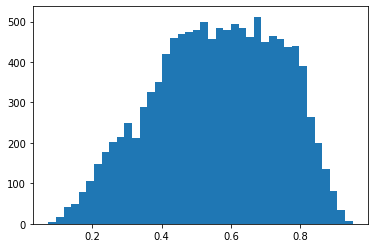

In [43]:
plt.hist(distr_1259, bins=40)

In [ ]:
# 134 -> 98
# 805 -> что-то ещё
# 207 -> 603
# 1259 -> 907

In [53]:
id_to_desc[id_to_desc.text_cluster == 36]

,1,text_cluster
19,Регистрация пользователя ЕСИА (СМЭВ 2),36
218,Регистрация ЕСИА (СМЭВ 3),36
907,Восстановление пароля пользователя ЕСИА,36
1170,Получение статуса заявки на регистрацию ЕСИА,36
1259,Регистрация пользователя ЕСИА,36


In [51]:
id_to_desc.loc[1259]

1               Регистрация пользователя ЕСИА
text_cluster                               36
Name: 1259, dtype: object

In [66]:
loaded_train_dataset.service_title.value_counts()[:25]#.reindex([19, 218, 907, 1170, 1259])

134     63798
603     35500
98      34554
1169    23122
4       15526
1259    15344
234     14302
207     13319
524     13041
907     11642
412     10646
805      9690
604      9558
1020     8618
491      8487
651      7208
1205     6747
1107     5915
901      5451
218      5400
1220     5014
692      4746
178      4637
870      4613
949      4211
Name: service_title, dtype: int64

---

In [103]:
preds_df = pd.DataFrame(
    data=preds.flatten(), 
    index=loaded_test_dataset['requester'],
    columns=['service_title'],
    dtype=int
)

In [104]:
preds_df

,service_title
requester,
5492,1259
5633,1205
5650,134
5872,263
5922,134
...,...
321044179,678
321044369,207
321062555,240


In [80]:
sample_subm = pd.read_csv(irkutsk_ds_path+'sample_submission.csv')
sample_subm

,requester,service_title
0,83029018,1
1,123998836,1
2,184301121,1
3,54344611,1
4,184299902,1
...,...,...
44439,27213855,1
44440,64899947,1
44441,23695212,1
44442,72707269,1


In [105]:
preds_df.service_title.value_counts().head(15)

134     4649
603     4032
907     3285
98      2965
207     2658
1259    2338
901     2227
1205    1980
815     1402
4       1380
234     1380
155     1227
218     1144
1020     900
604      801
Name: service_title, dtype: int64

In [102]:
pd.Series(preds).value_counts().iloc[:15]

134.0     4649
603.0     4032
907.0     3285
98.0      2965
207.0     2658
1259.0    2338
901.0     2227
1205.0    1980
815.0     1402
234.0     1380
4.0       1380
155.0     1227
218.0     1144
1020.0     900
604.0      801
dtype: int64

In [82]:
set(sample_subm.requester) - set(loaded_test_dataset.requester.astype(int))

{67480424}

In [106]:
preds_df.loc[67480424, 'service_title'] = 134
preds_df

,service_title
requester,
5492,1259.0
5633,1205.0
5650,134.0
5872,263.0
5922,134.0
...,...
321044369,207.0
321062555,240.0
321064845,1089.0


In [107]:
preds_df.reset_index(inplace=True)
preds_df.requester = preds_df.requester.astype(int)
preds_df.set_index('requester', inplace=True)

preds_df.service_title = preds_df.service_title.astype(int)

In [88]:
#preds_df['service_title'] = 524

In [108]:
preds_df

,service_title
requester,
5492,1259
5633,1205
5650,134
5872,263
5922,134
...,...
321044369,207
321062555,240
321064845,1089


In [109]:
preds_df.loc[sample_subm['requester']].reset_index().to_csv(global_path+'subm.csv')

In [110]:
preds_df.loc[sample_subm['requester']].reset_index()

,requester,service_title
0,83029018,1220
1,123998836,1018
2,184301121,134
3,54344611,907
4,184299902,603
...,...,...
44439,27213855,207
44440,64899947,98
44441,23695212,155
44442,72707269,1089


---

In [ ]:
subm2322 = pd.read_csv(global_path+'subm2322.csv')

In [ ]:
subm2322['service_title'] = 801

In [ ]:
subm2322.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
subm2322.to_csv(global_path+'subm2322_changed.csv')

In [ ]:
subm2322